# LSTM Prediction of Petroleum Price

This Jupyter notebook aims at using the LSTM neural network to recognize the multi-variate data of various types of weekly petrol prices from 1996 - 2020. I will try to use the network to predict the future petrol price up to 2022. 

Data obtained from Kaggle:
https://www.kaggle.com/mruanova/us-gasoline-and-diesel-retail-prices-19952021

Written by Shing Chi Leung at 15 Feb 2021

# 0. Data Fetching and Preprocessing

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("gdrive")

Mounted at gdrive


Read the csv datafile and do data operation

In [ ]:
file_path = "gdrive/MyDrive/Colab Notebooks/petrol_price.csv"

def read_file(file_path):
  df = pd.read_csv(file_path)
  return df

df = read_file(file_path)
print(df.tail(5))
print(df.shape)

df["Date"] = pd.to_datetime(df["Date"])

            Date     A1     A2     A3     R1  ...     M3     P1     P2     P3     D1
1356  12/28/2020  2.330  2.225  2.535  2.243  ...  2.858  2.889  2.770  3.031  2.635
1357  01/04/2021  2.336  2.227  2.549  2.249  ...  2.867  2.895  2.771  3.042  2.640
1358  01/11/2021  2.403  2.298  2.610  2.317  ...  2.927  2.959  2.839  3.101  2.670
1359  01/18/2021  2.464  2.351  2.688  2.379  ...  2.995  3.014  2.885  3.166  2.696
1360  01/25/2021  2.478  2.363  2.703  2.392  ...  3.014  3.033  2.900  3.191  2.716

[5 rows x 14 columns]
(1361, 14)


Let us plot the datafile to check if there are interesting points of notice. 

Text(0, 0.5, 'Regular All, Conv. and Reform. petrol price')

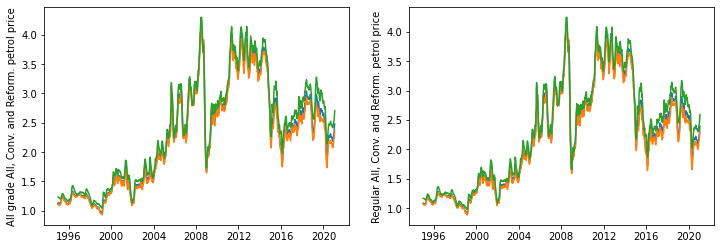

In [ ]:
# plot the data to see their trend

fig1, (ax1a, ax1b) = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
#plt.xticks(rotation=90)

ax1a.plot(df["Date"], df["A1"])
ax1a.plot(df["Date"], df["A2"])
ax1a.plot(df["Date"], df["A3"])
ax1a.set_ylabel("All grade All, Conv. and Reform. petrol price")


ax1b.plot(df["Date"], df["R1"])
ax1b.plot(df["Date"], df["R2"])
ax1b.plot(df["Date"], df["R3"])
ax1b.set_ylabel("Regular All, Conv. and Reform. petrol price")

This price trend suggests that there is not much variations among different brands, so to a good approximation I can pick a particular brand and do the machine learning.

Before that I need to prepare the training and testing data

In [ ]:
test_size = 0.2
lookback = 10

price_data = df["A1"].to_numpy()
print("data size = {}".format(price_data.shape))

price_data = price_data.reshape(price_data.shape[0], -1)
print("Reshaped data size = {}".format(price_data.shape))

# build the transofrmation function to scale the raw data
scaler = MinMaxScaler()
scaler.fit(price_data)
scaled_price_data = scaler.transform(price_data)

# prepare the list for training
x_all = []
y_all = []

for i in range(lookback, price_data.shape[0], 1):
  x_all.append(price_data[i-lookback:i,0])
  y_all.append(price_data[i,0])

# split the dataset into training and testing set
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=test_size, shuffle=False)

# convert it to numpy array for manipulation
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], -1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], -1)

print("x_train shape = {}".format(x_train.shape))
print("y_train shape = {}".format(y_train.shape))

data size = (1361,)
Reshaped data size = (1361, 1)
x_train shape = (1080, 10, 1)
y_train shape = (1080,)


# 1. LSTM Network Building

Due to the small amount of data, I will use a minimal LSTM network to start with, ti see if the code can produce some reasonable results. 

In [ ]:
def build_model(input_shape):
  model = Sequential()
  model.add(LSTM(20, input_shape=input_shape))
  model.add(Dense(1, activation="relu"))
  return model

model = build_model(x_train[0].shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def compile_model(model):
  model.compile(optimizer="adam", loss="mse", metrics=["mse"])

compile_model(model)

In [ ]:
def train_model(model, x_train, y_train):
  history = model.fit(x_train, y_train, batch_size=16, epochs=20, verbose=1, validation_split=0.2)
  return history

history = train_model(model, x_train, y_train)
#print(history.history["mse"])

Epoch 1/20
54/54 [==============================] - 2s 14ms/step - loss: 1.1241 - mse: 1.1241 - val_loss: 0.3941 - val_mse: 0.3941
Epoch 2/20
54/54 [==============================] - 0s 5ms/step - loss: 0.0994 - mse: 0.0994 - val_loss: 0.1013 - val_mse: 0.1013
Epoch 3/20
54/54 [==============================] - 0s 5ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 4/20
54/54 [==============================] - 0s 5ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 6/20
54/54 [==============================] - 0s 5ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0200 - val_mse: 0.0200
Epoch 7/20
54/54 [==============================] - 0s 6ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 8/20
54/54 [==============================] - 0s 6ms/step - loss: 0.0093 - mse: 0.0

The MSE in both training and valication are comparable and are both simultaneously decreasing. This suggests that the current size of data is sufficient to prevent overfitting. 

Let us plot the training record to see how well/poor the training is.

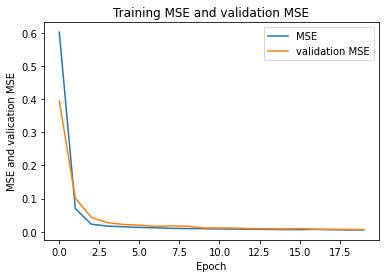

In [ ]:
fig2, ax2 = plt.subplots(nrows=1, ncols=1)

ax2.plot(history.history["mse"], label="MSE")
ax2.plot(history.history["val_mse"], label="validation MSE")

ax2.set_title("Training MSE and validation MSE")
ax2.set_ylabel("MSE and valication MSE")
ax2.set_xlabel("Epoch")
ax2.legend()

Both training and validation loss approach zero within tens of steps. 

Then we want to examine the accuracy for the test set

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=16)

print("Loss is ", results[0])

17/17 [==============================] - 0s 2ms/step - loss: 0.0038 - mse: 0.0038
Loss is  0.0038134329952299595


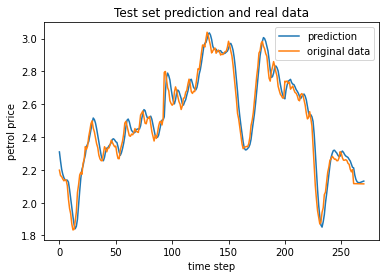

In [ ]:
y_pred = model.predict(x_test)

y_pred = np.array(y_pred)

fig3, ax3 = plt.subplots(nrows=1, ncols=1)
ax3.plot(y_pred[:,0], label="prediction")
ax3.plot(y_test, label="original data")

ax3.set_xlabel("time step")
ax3.set_ylabel("petrol price")
ax3.set_title("Test set prediction and real data")
ax3.legend()

Since the original data set can be reproduced with a good accuracy, I proceed to do a continous prediction until the end of January 2021, so I need to do an extrapolation of about 100 steps and check the results. 

# 2. Using LSTM for doing continuous prediction

In [ ]:
pred_steps = 50

raw_data = np.array(x_all[-1])
print("The first set of data is: {} wiht a shape {}".format(raw_data, raw_data.shape))

# turn the 1D pipe data in a 1 x lookback x 1 (feature) data
raw_data = raw_data.reshape(1, raw_data.shape[0])
raw_data = raw_data.reshape(raw_data.shape[0], raw_data.shape[1], 1)
print("morphed raw_data shape: {}".format(raw_data.shape))

# the data to be visualized
new_pred = []

for i in range(pred_steps):
  pred = model.predict(raw_data)
  new_pred.append(pred[0][0])
  
  # then shift the raw data
  raw_data[0,0:lookback-1,0] = raw_data[0,1:lookback,0]
  raw_data[0,lookback-1,0] = pred[0][0]
  #print(raw_data)

print(new_pred)

The first set of data is: [2.202 2.194 2.211 2.246 2.247 2.311 2.33  2.336 2.403 2.464] wiht a shape (10,)
morphed raw_data shape: (1, 10, 1)
[2.452567, 2.4775734, 2.4999719, 2.5205789, 2.539839, 2.5568233, 2.5732367, 2.5881724, 2.6012866, 2.6143777, 2.6278253, 2.639913, 2.6514828, 2.6625779, 2.673254, 2.6835656, 2.6935272, 2.7031841, 2.71255, 2.7216167, 2.7304146, 2.7389884, 2.7473383, 2.7554765, 2.763415, 2.7711637, 2.778732, 2.7861292, 2.7933626, 2.8004403, 2.8073676, 2.8141503, 2.820794, 2.8273041, 2.8336847, 2.8399403, 2.846075, 2.8520927, 2.8579974, 2.8637917, 2.8694792, 2.875063, 2.8805459, 2.885931, 2.8912206, 2.8964171, 2.9015236, 2.9065418, 2.9114742, 2.9163227]


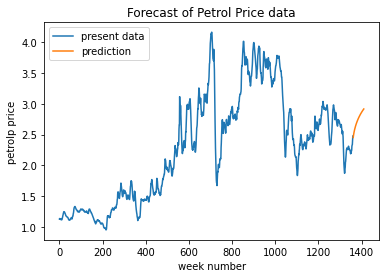

In [ ]:
fig4, ax4 = plt.subplots(nrows=1, ncols=1)

curr_data = list(df["A1"])
x_range = [i + len(x_all) + 10 for i in range(pred_steps)]

ax4.plot(curr_data, label="present data")
ax4.plot(x_range, new_pred, label="prediction")

ax4.set_title("Forecast of Petrol Price data")
ax4.set_xlabel("week number")
ax4.set_ylabel("petrolp price")
ax4.legend()

Without the input of real data, the LSTM prediction can only preserve the large scale pattern which it recognized from the last avabilable set of data. And it predicts that in 2022 the petrol price will slow return to its former peak in week 1200 (Year 2019) at about $3. This can be expected as there is already a rising trend showing in the petrol price. Meanwhilethere is no significant resistance points in recent years. 